In [1]:
import sys
import matplotlib.pyplot as plt
import h5py
from tqdm import tqdm
import numpy as np
from keras.utils.np_utils import to_categorical
from sklearn.utils import shuffle
import torch

from tools import prepare, mixup, preprocess, noise, getCorrects
from byol_pytorch import BYOL

classes_list = [
    #"Rhinolophus capensis",
    #"Rhinolophus smithersi",
    "Rhinolophus clivosus",
    "Rhinolophus simulator",
    #"Myotis tricolor",
    #"Myotis welwitschii",
    "Pipistrellus hesperidus",
    #"Eptesicus hottentotus",
    "Minopterus natalensis",
    "Taphozous mauritianus",
    #"Scotophilus dinganii",
    "Cistugo lesueuri",
    "Laephotis capensis",
    #"Rousettus aegyptiacus",
    "Chaerephon pumilus",
    "Tadarida aegyptiaca",
    #"Vespertilionidae",
    #"Kerivoula",
    "Pesticide Spray",
    #"Unlabeled",
]
classes = { classes_list[i]: i for i in range(0, len(classes_list)) }

2023-03-27 17:44:57.542521: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-27 17:44:58.115422: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-27 17:45:00.565281: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Dataset

In [2]:
nfft = 512
num_bands = nfft // 2 + 1

max_len = 60
patch_len = 44
patch_skip = 22

samples_per_step = patch_skip * (nfft // 4)
seq_len = (max_len + 1) * samples_per_step
seq_skip = seq_len // 4

In [3]:
data_path = "../UFS/prepared_signal.h5"
X_train, Y_train, X_test, Y_test, X_val, Y_val = prepare(data_path, {"Unlabeled": 0}, seq_len, seq_skip,
                                                                     max_seqs=10000, min_seqs=100)

100%|██████████| 47/47 [00:08<00:00,  5.34it/s]


# Model

In [4]:
import time
import datetime
import torch
import torch.nn as nn
import math
from torch.cuda.amp import autocast
from torch.utils.data import TensorDataset, DataLoader

from torchsummary import summary
from torchmetrics.functional import f1_score

from SAM import SAM
from ASL import AsymmetricLoss
from BigBAT_SimCLR import BigBAT

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, device_ids=[0, 1])

In [6]:
big_patch_embedding = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3, 5), stride=(2, 3), padding=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            nn.Conv2d(16, 32, kernel_size=(3, 5), stride=(2, 3), padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 3), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=5, stride=2, padding=1),

            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
    
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

#summary(big_patch_embedding, (1, 44, 257))

In [7]:
d_model = 64
nhead = 2
dim_feedforward = 32
num_layers = 2
dropout = 0.3
classifier_dropout = 0.3
num_classes = len(list(classes))

BATencode = BigBAT(
    max_len=max_len,
    patch_len=patch_len,
    patch_skip=patch_skip,
    d_model=d_model,
    num_classes=len(list(classes)),
    patch_embedding=big_patch_embedding,
    nhead=nhead,
    dim_feedforward=dim_feedforward,
    num_layers=num_layers,
    dropout=dropout,
    classifier_dropout=classifier_dropout,
)

In [8]:
import torchvision.transforms as T
import random

class RandomApply(nn.Module):
    def __init__(self, fn, p):
        super().__init__()
        self.fn = fn
        self.p = p
    def forward(self, x):
        if random.random() > self.p:
            return x
        return self.fn(x)

custom_augment_fn = nn.Sequential(
    RandomApply(T.ColorJitter(0.8, 0.8, 0.8, 0.2), p=0.8),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    RandomApply(T.GaussianBlur((23, 23), (1.5, 1.5)), p=0.3),
    RandomApply(noise, p=0.5),
    T.RandomErasing()
    #T.RandomResizedCrop((1343, 257))
)

model = BYOL(
    BATencode,
    image_size = (1, 1343, 257),
    hidden_layer = 'classifier',
    projection_size = 32,
    projection_hidden_size = 64,
    augment_fn = custom_augment_fn
)

model.to(device)

BYOL(
  (net): BigBAT(
    (patch_embedding): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 5), stride=(2, 3), padding=(3, 3))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 32, kernel_size=(3, 5), stride=(2, 3), padding=(3, 3))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 3), padding=(1, 1))
      (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU()
      (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 3), padding=(1, 1))
      (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU()
      (13): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (14): BatchNorm2d(64, eps=

In [9]:
batch_size = 128
epochs = 50
lr = 0.00001

In [11]:
train_data = TensorDataset(X_train, Y_train)
test_data = TensorDataset(X_test, Y_test)
val_data = TensorDataset(X_val, Y_val)

train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

(1343, 257)


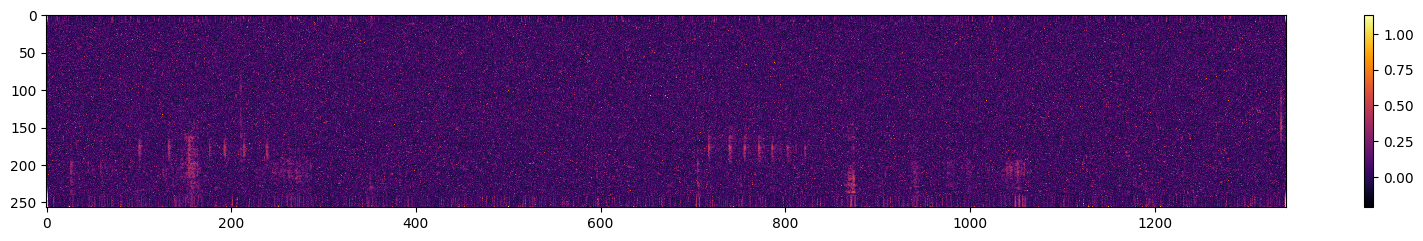

In [12]:
def plot_sequence(X, k):
    plt.figure(figsize = (20, 2.5))
    x = X[k].cpu().detach().numpy()
    plt.imshow(np.rot90(x), interpolation='nearest', aspect='auto', cmap='inferno')
    plt.colorbar()
    label_list = []
    print(x.shape)

k = np.random.randint(0, batch_size)
X1, Y1 = next(iter(train_loader))
X1, Y1 = X1.cuda(), Y1.cuda()
X1 = preprocess(X1)
X1 = custom_augment_fn(X1.unsqueeze(1))
plot_sequence(X1.squeeze(1), k)

In [13]:
criterion = None
optimizer = torch.optim.Adam(model.parameters(), lr=lr, )
    
#scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=5)
scheduler = None

min_val_loss = np.inf

torch.autograd.set_detect_anomaly(True)

In [18]:
def train_epoch(model, epoch, criterion, optimizer, scheduler, dataloader, device):
    model.train()
    
    running_loss = 0.0
    
    num_batches = len(dataloader)
    num_samples = len(dataloader.dataset)
    
    for batch, (inputs, labels) in enumerate(tqdm(dataloader)):
        # Transfer Data to GPU if available
        inputs, labels = inputs.to(device), labels.to(device)
        inputs, _ = mixup(inputs, labels, min_seq=1, max_seq=3, p_min=0.3)
        inputs = preprocess(inputs).unsqueeze(1)
         
        # Clear the gradients
        optimizer.zero_grad()
        
        # Forward Pass
        loss = model(inputs)
        
        # Calculate gradients
        loss.backward()
        
        # Update Weights
        optimizer.step()
        model.update_moving_average()
        
        # Calculate Loss
        running_loss += loss.item() * inputs.size(0)
    
        # Perform learning rate step
        #scheduler.step(epoch + batch / num_batches)
            
    epoch_loss = running_loss / num_samples
    
    return epoch_loss

In [19]:
def test_epoch(model, epoch, criterion, optimizer, dataloader, device):
    model.eval()
    
    num_batches = len(dataloader)
    num_samples = len(dataloader.dataset)
    
    with torch.no_grad():
        running_loss = 0.0

        for batch, (inputs, labels) in enumerate(tqdm(dataloader)):
            # Transfer Data to GPU if available
            inputs = inputs.to(device)
            inputs = preprocess(inputs).unsqueeze(1)
                    
            # Clear the gradients
            optimizer.zero_grad()

            # Forward Pass
            loss = model(inputs)

            # Calculate Loss
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / num_samples
    
    return epoch_loss

# Training

In [20]:
import wandb

wandb_config = {
    "epochs": epochs,
    "lr": lr,
    "batch_size": batch_size
}

wandb.init(project="BigBAT-pretrain", entity="frankfundel", config=wandb_config)

In [22]:
for epoch in range(epochs):
    end = time.time()
    print(f"==================== Starting at epoch {epoch} ====================", flush=True)
    
    train_loss = train_epoch(model, epoch, criterion, optimizer, scheduler, train_loader, device)
    print('Training loss: {:.4f}'.format(train_loss), flush=True)
    
    val_loss = test_epoch(model, epoch, criterion, optimizer, val_loader, device)
    print('Validation loss: {:.4f}'.format(val_loss), flush=True)
    
    wandb.log({
        "train_loss": train_loss,
        "val_loss": val_loss,
    })
        
    if min_val_loss > val_loss:
        print('val_loss decreased, saving model', flush=True)
        min_val_loss = val_loss
        
        # Saving State Dict
        torch.save(BATencode.state_dict(), 'BigBAT-BYOL.pth')

==================== Starting at epoch 0 ====================


100%|██████████| 157/157 [01:42<00:00,  1.53it/s]

Training loss: 3.9132



100%|██████████| 157/157 [00:37<00:00,  4.17it/s]

Validation loss: 3.7507
val_loss decreased, saving model


==================== Starting at epoch 1 ====================


100%|██████████| 157/157 [01:43<00:00,  1.52it/s]

Training loss: 3.3439



100%|██████████| 157/157 [00:37<00:00,  4.18it/s]

Validation loss: 3.1232
val_loss decreased, saving model
==================== Starting at epoch 2 ====================



100%|██████████| 157/157 [01:44<00:00,  1.51it/s]

Training loss: 2.7833



100%|██████████| 157/157 [00:37<00:00,  4.14it/s]

Validation loss: 2.9568
val_loss decreased, saving model
==================== Starting at epoch 3 ====================



100%|██████████| 157/157 [01:44<00:00,  1.50it/s]

Training loss: 2.3118



100%|██████████| 157/157 [00:36<00:00,  4.35it/s]

Validation loss: 2.6919
val_loss decreased, saving model
==================== Starting at epoch 4 ====================



100%|██████████| 157/157 [01:41<00:00,  1.55it/s]

Training loss: 1.8879



100%|██████████| 157/157 [00:35<00:00,  4.41it/s]

Validation loss: 2.4583
val_loss decreased, saving model
==================== Starting at epoch 5 ====================



100%|██████████| 157/157 [01:38<00:00,  1.59it/s]

Training loss: 1.5060



100%|██████████| 157/157 [00:35<00:00,  4.39it/s]

Validation loss: 2.3415
val_loss decreased, saving model
==================== Starting at epoch 6 ====================



100%|██████████| 157/157 [01:41<00:00,  1.55it/s]


Training loss: 1.1969


100%|██████████| 157/157 [00:34<00:00,  4.53it/s]

Validation loss: 2.3451
==================== Starting at epoch 7 ====================



100%|██████████| 157/157 [01:38<00:00,  1.60it/s]

Training loss: 0.9416



100%|██████████| 157/157 [00:36<00:00,  4.34it/s]

Validation loss: 1.8628
val_loss decreased, saving model
==================== Starting at epoch 8 ====================



100%|██████████| 157/157 [01:42<00:00,  1.52it/s]

Training loss: 0.7656



100%|██████████| 157/157 [00:35<00:00,  4.38it/s]

Validation loss: 2.4365
==================== Starting at epoch 9 ====================



100%|██████████| 157/157 [01:42<00:00,  1.54it/s]

Training loss: 0.6188



100%|██████████| 157/157 [00:35<00:00,  4.47it/s]

Validation loss: 1.9423
==================== Starting at epoch 10 ====================



100%|██████████| 157/157 [01:41<00:00,  1.55it/s]

Training loss: 0.5130



100%|██████████| 157/157 [00:35<00:00,  4.41it/s]

Validation loss: 1.3895
val_loss decreased, saving model


==================== Starting at epoch 11 ====================


100%|██████████| 157/157 [01:42<00:00,  1.53it/s]


Training loss: 0.4364


100%|██████████| 157/157 [00:36<00:00,  4.25it/s]

Validation loss: 1.8687
==================== Starting at epoch 12 ====================



100%|██████████| 157/157 [01:46<00:00,  1.47it/s]

Training loss: 0.3702



100%|██████████| 157/157 [00:35<00:00,  4.39it/s]

Validation loss: 1.1582
val_loss decreased, saving model
==================== Starting at epoch 13 ====================



100%|██████████| 157/157 [01:40<00:00,  1.56it/s]

Training loss: 0.3192



100%|██████████| 157/157 [00:36<00:00,  4.28it/s]

Validation loss: 1.5932
==================== Starting at epoch 14 ====================



100%|██████████| 157/157 [01:42<00:00,  1.54it/s]

Training loss: 0.2809



100%|██████████| 157/157 [00:34<00:00,  4.61it/s]

Validation loss: 1.5932
==================== Starting at epoch 15 ====================



100%|██████████| 157/157 [01:42<00:00,  1.53it/s]

Training loss: 0.2439



100%|██████████| 157/157 [00:34<00:00,  4.49it/s]

Validation loss: 1.7086
==================== Starting at epoch 16 ====================



  6%|▋         | 10/157 [00:06<01:42,  1.44it/s]


KeyboardInterrupt: 

In [23]:
# Load after training
BATencode.load_state_dict(torch.load('BigBAT-BYOL.pth'))

<All keys matched successfully>

wandb: Waiting for W&B process to finish... (success).


# Evaluation